In [1]:
!wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip -P data

--2024-02-29 07:24:06--  https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip
Resolving www.cis.upenn.edu (www.cis.upenn.edu)... 158.130.69.163, 2607:f470:8:64:5ea5::d
Connecting to www.cis.upenn.edu (www.cis.upenn.edu)|158.130.69.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53723336 (51M) [application/zip]
Saving to: ‘data/PennFudanPed.zip’

PennFudanPed.zip    100%[===================>]  51.23M  85.0MB/s    in 0.6s    

2024-02-29 07:24:07 (85.0 MB/s) - ‘data/PennFudanPed.zip’ saved [53723336/53723336]



In [2]:
!cd data && unzip PennFudanPed.zip

Archive:  PennFudanPed.zip
   creating: PennFudanPed/
  inflating: PennFudanPed/added-object-list.txt  
   creating: PennFudanPed/Annotation/
  inflating: PennFudanPed/Annotation/FudanPed00001.txt  
  inflating: PennFudanPed/Annotation/FudanPed00002.txt  
  inflating: PennFudanPed/Annotation/FudanPed00003.txt  
  inflating: PennFudanPed/Annotation/FudanPed00004.txt  
  inflating: PennFudanPed/Annotation/FudanPed00005.txt  
  inflating: PennFudanPed/Annotation/FudanPed00006.txt  
  inflating: PennFudanPed/Annotation/FudanPed00007.txt  
  inflating: PennFudanPed/Annotation/FudanPed00008.txt  
  inflating: PennFudanPed/Annotation/FudanPed00009.txt  
  inflating: PennFudanPed/Annotation/FudanPed00010.txt  
  inflating: PennFudanPed/Annotation/FudanPed00011.txt  
  inflating: PennFudanPed/Annotation/FudanPed00012.txt  
  inflating: PennFudanPed/Annotation/FudanPed00013.txt  
  inflating: PennFudanPed/Annotation/FudanPed00014.txt  
  inflating: PennFudanPed/Annotation/FudanPed00015.txt  
  i

In [3]:
import matplotlib.pyplot as plt
from torchvision.io import read_image
import os

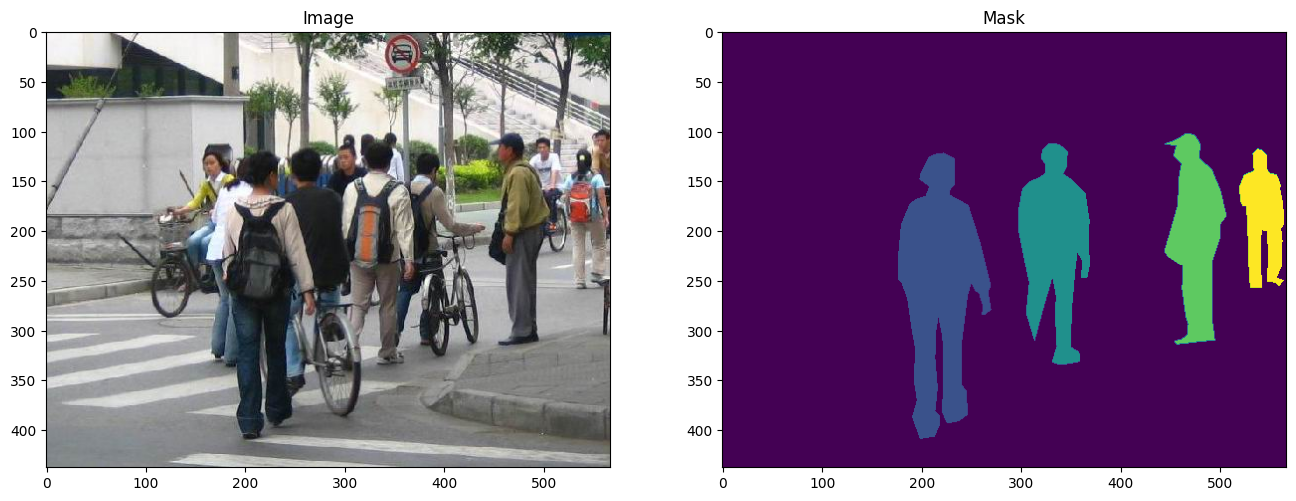

In [4]:
image = read_image("data/PennFudanPed/PNGImages/FudanPed00046.png")
mask = read_image("data/PennFudanPed/PedMasks/FudanPed00046_mask.png")

plt.figure(figsize=(16, 8))
plt.subplot(121)
plt.title("Image")
plt.imshow(image.permute(1, 2, 0))
plt.subplot(122)
plt.title("Mask")
plt.imshow(mask.permute(1, 2, 0))

In [5]:
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_eval.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py")

0

In [6]:
import os
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from engine import train_one_epoch, evaluate
from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F
from torchvision.transforms import v2 as T
import utils

class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        # Load all image files, sorting them to ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # Load images and masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = read_image(img_path)
        mask = read_image(mask_path)
        # Instances are encoded as different colors
        obj_ids = torch.unique(mask)
        # First id is the background, so remove it
        obj_ids = obj_ids[1:]
        num_objs = len(obj_ids)

        # Split the color-encoded mask into a set of binary masks
        masks = (mask == obj_ids[:, None, None]).to(dtype=torch.uint8)

        # Get bounding box coordinates for each mask
        boxes = masks_to_boxes(masks)

        # There is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)

        image_id = idx
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # Suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # Wrap sample and targets into torchvision tv_tensors
        img = tv_tensors.Image(img)
        target = {}
        target["boxes"] = tv_tensors.BoundingBoxes(boxes, format="XYXY", canvas_size=F.get_size(img))
        target["masks"] = tv_tensors.Mask(masks)
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)


def get_model_instance_segmentation(num_classes):
    # Load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")

    # Get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # Replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # Now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # Replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(
        in_features_mask,
        hidden_layer,
        num_classes
    )

    return model


def get_transform(train):
    transforms = []
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    transforms.append(T.ToDtype(torch.float, scale=True))
    transforms.append(T.ToPureTensor())
    return T.Compose(transforms)


# Load the dataset
dataset = PennFudanDataset('data/PennFudanPed', get_transform(train=True))
dataset_test = PennFudanDataset('data/PennFudanPed', get_transform(train=False))

# Define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    num_workers=4,
    collate_fn=utils.collate_fn
)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=1,
    shuffle=False,
    num_workers=4,
    collate_fn=utils.collate_fn
)

# Get the model for instance segmentation
model = get_model_instance_segmentation(num_classes=2)

# Define the device for training
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Define the optimizer and scheduler
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Train the model
num_epochs = 2
for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    lr_scheduler.step()
    evaluate(model, data_loader_test, device=device)
    print("-" * 50)

print("Training completed!")


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:03<00:00, 45.6MB/s]


Epoch: [0]  [ 0/85]  eta: 0:06:40  lr: 0.000064  loss: 4.1140 (4.1140)  loss_classifier: 0.8263 (0.8263)  loss_box_reg: 0.1739 (0.1739)  loss_mask: 3.0561 (3.0561)  loss_objectness: 0.0503 (0.0503)  loss_rpn_box_reg: 0.0074 (0.0074)  time: 4.7167  data: 0.3593  max mem: 2316
Epoch: [0]  [10/85]  eta: 0:01:10  lr: 0.000659  loss: 1.7609 (2.6166)  loss_classifier: 0.5475 (0.5680)  loss_box_reg: 0.3153 (0.3176)  loss_mask: 0.9915 (1.6993)  loss_objectness: 0.0282 (0.0268)  loss_rpn_box_reg: 0.0041 (0.0050)  time: 0.9372  data: 0.0411  max mem: 2874
Epoch: [0]  [20/85]  eta: 0:00:49  lr: 0.001254  loss: 1.2640 (1.7279)  loss_classifier: 0.2460 (0.3849)  loss_box_reg: 0.2786 (0.2853)  loss_mask: 0.5658 (1.0297)  loss_objectness: 0.0190 (0.0222)  loss_rpn_box_reg: 0.0039 (0.0058)  time: 0.5636  data: 0.0101  max mem: 2874
Epoch: [0]  [30/85]  eta: 0:00:37  lr: 0.001848  loss: 0.5123 (1.3398)  loss_classifier: 0.1122 (0.2947)  loss_box_reg: 0.1748 (0.2557)  loss_mask: 0.2193 (0.7655)  loss_ob

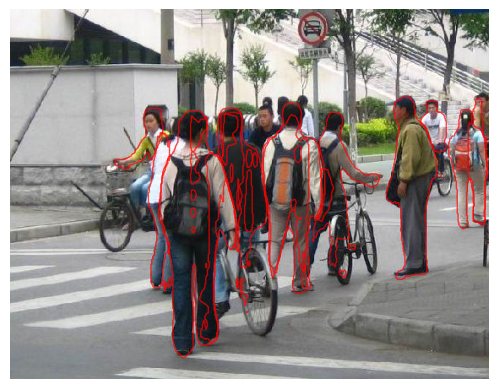

In [15]:
import torch
import torchvision.transforms as T
from torchvision.io import read_image
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from torchvision.ops.boxes import box_convert

def evaluate_image(model, image_path, transform, device):
    # Read and transform the image
    image = read_image(image_path)
    image = transform(image).unsqueeze(0).to(device)

    # Make prediction
    with torch.no_grad():
        model.eval()
        prediction = model(image)

    # Convert prediction to masks
    masks = prediction[0]['masks'] > 0.5  # adjust threshold as needed

    # Convert boxes from (x, y, w, h) to (x1, y1, x2, y2)
    boxes = prediction[0]['boxes']
    boxes = box_convert(boxes, in_fmt='xywh', out_fmt='xyxy')

    # Move tensors to CPU for plotting with Matplotlib
    image = image.cpu().squeeze()
    masks = masks.cpu().numpy()
    boxes = boxes.cpu().numpy()

    # Plot the original image with predicted masks and bounding boxes
    plt.imshow(image.permute(1, 2, 0))
    for i in range(masks.shape[0]):
        for j in range(masks.shape[1]):  # Iterate over channels
            contours = plt.contour(masks[i, j], colors='r', linewidths=1, alpha=0.7)
    plt.axis('off')
    plt.show()

# Example usage
image_path = "data/PennFudanPed/PNGImages/FudanPed00046.png"
evaluate_image(model, image_path, eval_transform, device)

